In [1]:
protein = "MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG"
from disassembly.simulate_proteolysis import (
    ProteolysisSimulator,
    enzyme_set,
    enzyme,
)
from disassembly.util import amino_acids

n_generate = 250

k_enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
    ],
    [1],
    [1],
)

kr_enzymes = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
    ],
    [1],
    [1],
)

viat_enzymes = enzyme_set(
    [
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1],
    [1],
)

krviat_enzymes = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1],
    [1, 1],
)

random_enzymes = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

In [2]:
generated_peptidomes = {"name": [], "peptidome": []}

names = ["kr", "viat", "random"]

ps = ProteolysisSimulator(verbose=False)
for enz, name in zip(
    [kr_enzymes, viat_enzymes, random_enzymes], names
):
    print(name)
    for i in range(10):
        print(f"\r{i}", end="", flush=True)
        generated_peptidome = ps.simulate_proteolysis(
            protein,
            n_start=1,
            n_generate=n_generate,
            endo_or_exo_probability=[0.9,0.1],
            enzymes=enz,
            graph=False,
        )
        generated_peptidomes["name"].append(f"{name}_{i}")
        generated_peptidomes["peptidome"].append(generated_peptidome)

kr
1

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:229: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values())


9viat
9random
9

In [3]:
from disassembly.util import KL, normalize_dict
from disassembly.estimate_parameters import compare

comparisons = {}
for i in range(len(generated_peptidomes["peptidome"])):
    name_comp_1 = generated_peptidomes["name"][i]
    peptidome_comp_1 = generated_peptidomes["peptidome"][i]
    comparisons[name_comp_1] = {}
    for j in range(len(generated_peptidomes["peptidome"])):
        name_comp_2 = generated_peptidomes["name"][j]
        peptidome_comp_2 = generated_peptidomes["peptidome"][j]
        p, q = compare(peptidome_comp_1, peptidome_comp_2)
        err = KL(p, q) + KL(q, p)
        comparisons[name_comp_1][name_comp_2] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


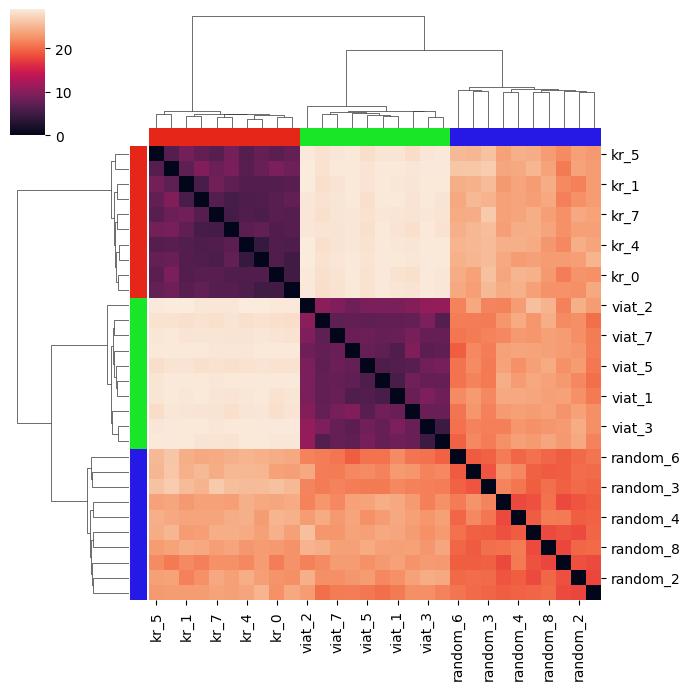

In [4]:
import seaborn as sns

lut = dict(zip(names, sns.hls_palette(len(names), l=0.5, s=0.8)))

lst = []
for i, n in enumerate(names):
    lst += [f"{n}"] * 10

row_colors = pd.DataFrame(lst)[0].map(lut)


sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)

In [5]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme


# Say we want to estimate parameters for K enzyme.
enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 0, 0],  # activities
    [1,0, 0],  # abundances
)

ps = ProteolysisSimulator()
true_dict, sequence_graph = ps.simulate_proteolysis(
    protein,
    n_start=1,
    n_generate=n_generate,
    endo_or_exo_probability=[0.9, 0.1],
    enzymes=enzymes,
    graph=True,
)

 77 / 250 (108)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:229: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values())


 249 / 250 (351)
32 unique peptides. 251 total


251
Endo iteration: 0
	V: 28.70 | 23.29
	I: 27.83 | 23.29
	L: 28.14 | 23.29
	E: 24.24 | 23.29
	Q: 27.64 | 23.29
	D: 27.40 | 23.29
	N: 27.97 | 23.29
	H: 27.44 | 23.29
	W: 23.33 | 23.29
	F: 23.01 | 23.29
F better!
	F: 27.04 | 23.01
	Y: 25.95 | 23.01
	R: 28.49 | 23.01
	K: 20.55 | 23.01
K better!
	K: 17.44 | 20.55
K better!
	K: 12.08 | 17.44
K better!
	K: 10.14 | 12.08
K better!
	K: 11.36 | 10.14
	S: 8.49 | 10.14
S better!
	S: 10.71 | 8.49
	T: 11.69 | 8.49
	M: 9.29 | 8.49
	A: 8.47 | 8.49
A better!
	A: 9.50 | 8.47
	G: 11.82 | 8.47
	P: 11.53 | 8.47
	C: 12.04 | 8.47
 exo: 13.76 | 10.17 (0.25)
 exo: 12.68 | 10.17 (0.25)
 exo: 11.54 | 10.17 (0.25)
 exo: 8.51 | 8.51 (0.30)
 exo: 9.73 | 8.51 (0.30)
 exo: 11.64 | 8.51 (0.30)
 exo: 9.25 | 8.51 (0.30)
 exo: 12.88 | 8.51 (0.30)
 exo: 13.73 | 8.51 (0.30)
 exo: 11.46 | 8.51 (0.30)
 exo: 12.39 | 8.51 (0.30)
 exo: 13.69 | 8.51 (0.30)
 exo: 10.48 | 8.51 (0.30)
 exo: 11.86 | 8.51 (0.30)
 exo: 11.50 | 8.51 (0.30)
 exo: 11.95 | 8.51 (0.30)
 exo: 10.22 | 8.51

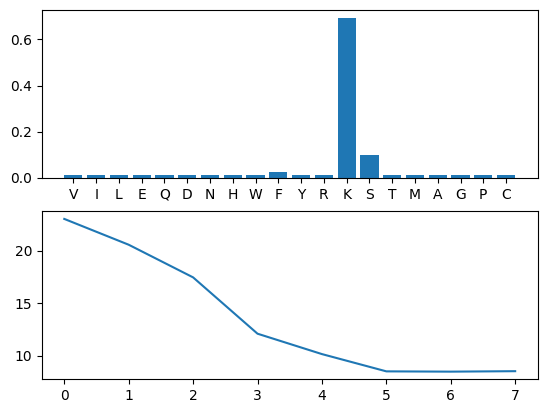

In [6]:
from disassembly.estimate_parameters import ParameterEstimator

pe = ParameterEstimator()

parameters = pe.estimate(
    protein, true_dict, n_iterations_endo=1, n_iterations_exo=20
)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].bar(parameters["endo"].keys(), parameters["endo"].values())
axs[1].plot(pe.best_losses)
print(parameters["exo"])

 199 / 200 | 1.70, kl: 1.44, reg: 0.27  | nz: 123 | 

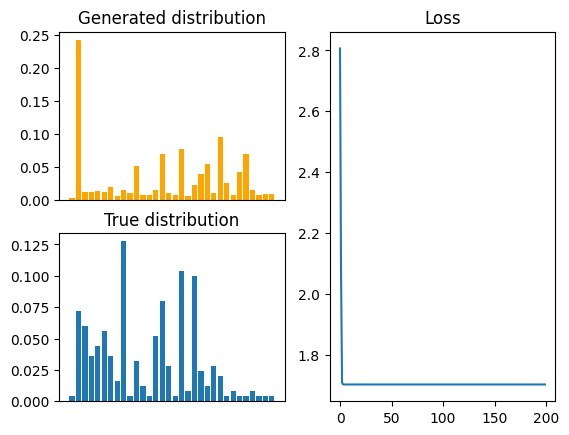

In [7]:
from disassembly.estimate_weights_gd import WeightEstimatorGD

wegd = WeightEstimatorGD(lr=0.1, n_iterations=200, lam1=0.01, lam2=0.01)

G = wegd.run(true_dict, verbose=True, parameters=parameters)
generated = wegd.generated
losses = wegd.losses
weights = wegd.weights

fig, axs = plt.subplot_mosaic(
    [["generated", "loss"], ["true", "loss"]], width_ratios=[2, 2]
)


axs["true"].bar(
    true_dict.keys(), [v / sum(true_dict.values()) for v in true_dict.values()]
)
axs["generated"].bar(
    generated[len(generated.keys()) - 1].keys(),
    generated[len(generated.keys()) - 1].values(),
    color="orange",
)
axs["loss"].plot(losses)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["loss"].set_title("Loss")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

0.7163309982486865

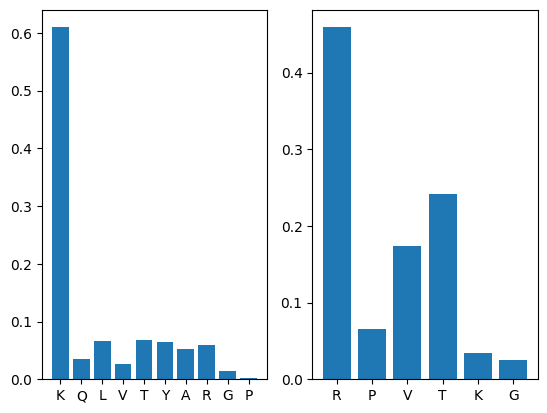

In [8]:
from disassembly.cut_site import get_p1

p1_endo, p1_exo,  n_endo, n_exo = get_p1(G, 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

0.800252566847856

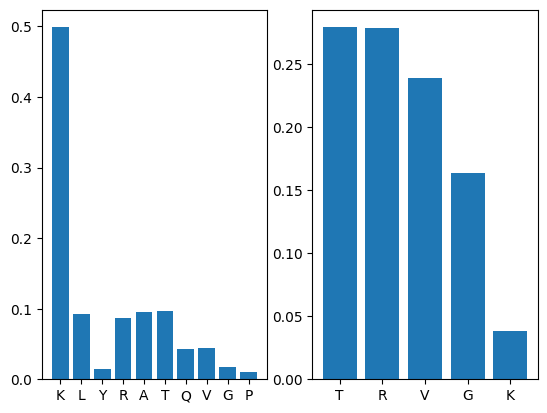

In [9]:

p1_endo, p1_exo,  n_endo, n_exo = get_p1(sequence_graph, 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

In [23]:
from disassembly.disassembly import get_disassembly_indexes_mc
from disassembly.disassembly import get_disassembly

print("Real")
real_disassembly_indexes = get_disassembly_indexes_mc(ps.format_graph(), N_particles=10000)
print(get_disassembly(true_dict, real_disassembly_indexes))
print("Estimated")
mc_di = get_disassembly_indexes_mc(G, 10000)
get_disassembly(true_dict, mc_di)

Real

 Averaged DI: 1.82
8.001569087203771
Estimated

 Averaged DI: 2.24


14.930292454910276

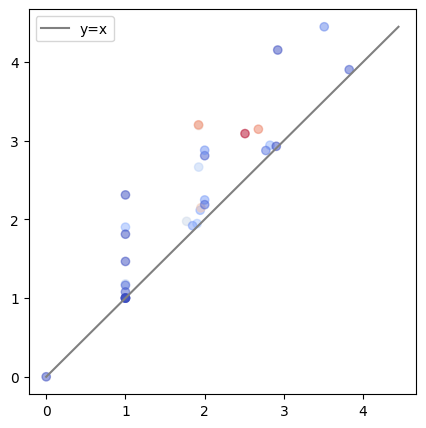

In [24]:
from disassembly.util import plot_di_correlation

plot_di_correlation(true_dict, real_disassembly_indexes, mc_di)

# Check if simulated proteolysis has a reasonable distance


In [12]:
import pandas as pd


df = pd.read_csv("../data/enzymes/processed.csv")
df = df[df["Protein Accession"] == "H4"]
df.set_index(["Peptide", "Protein Accession"], inplace=True)

In [13]:
pre_df = {}

for name, peptidome in zip(
    generated_peptidomes["name"], generated_peptidomes["peptidome"]
):
    pre_df[name] = peptidome
df_simulated = pd.DataFrame(pre_df)
df_simulated = df_simulated.reset_index().rename(columns={"index": "Peptide"})
df_simulated.head()

,Peptide,kr_0,kr_1,kr_2,kr_3,kr_4,kr_5,kr_6,kr_7,kr_8,...,random_0,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9
0,MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKR...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,RLARRGGVK,3.0,1.0,2.0,1.0,NaN,NaN,1.0,4.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,DAVTYTEHAKRKTVTAMDVVYAL,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GLGKGGAKRHR,1.0,NaN,NaN,2.0,1.0,NaN,NaN,4.0,2.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
4,VLRDNIQGITKPAIR,1.0,1.0,2.0,1.0,4.0,2.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
merged = df.reset_index().merge(df_simulated, left_on="Peptide", right_on="Peptide", how="outer")
merged = merged.set_index("Peptide").drop(columns=["Protein Accession"])
samples = merged.columns
merged

,cht1,cht2,cht3,cht4,cht5,cht6,cht7,cht8,cht9,cht10,...,random_0,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9
Peptide,,,,,,,,,,,,,,,,,,,,,
RKTVTAMDVVYALKR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALKR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
ENVIRDAVTYTEHAKRKTVTAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KVFLENVIRDAVTYTEHAKRKTVTAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGKGLGKGGAKRHRKVLRDNIQGITK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
HAKRKTVTAMDVVYALKRQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
VTAMDVVYALKRQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [15]:
data_dict = {}

for sample in samples:
    sample_data = merged[sample].dropna().reset_index()

    protein_dict = {}

    peptide_dict = {}

    for i, row in sample_data.iterrows():
        peptide = row["Peptide"]
        abundance = row[sample]
        peptide_dict[peptide] = abundance
    protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'cht1': {'MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG': {'RKTVTAMDVVYALKR': 0.0,
   'KTVTAMDVVYALKR': 0.0,
   'ENVIRDAVTYTEHAKRKTVTAM': 0.0,
   'KTVTAMDVVYALK': 0.0,
   'KVFLENVIRDAVTYTEHAKRKTVTAM': 0.0,
   'VIRDAVTYTEHAKRKTVTAM': 0.0,
   'VFLENVIRDAVTYTEHAKR': 0.0,
   'VFLENVIRDAVTY': 0.0,
   'TVTAMDVVYALKR': 0.0,
   'VFLENVIRDAVTYTEHAK': 0.0,
   'IRDAVTYTEHAKRKTVTAM': 0.0,
   'DNIQGITKPAIRR': 0.0,
   'DNIQGITKPAIR': 0.0,
   'VLRDNIQGITKPAIR': 1.0,
   'TAMDVVYALKR': 0.0,
   'RDNIQGITKPAIR': 2.0,
   'FLENVIRDAVTYT': 0.0,
   'FLENVIRDAVTYTEHA': 0.0,
   'VIRDAVTYTEHAK': 0.0,
   'VLRDNIQGITKPAIRR': 0.0,
   'VFLENVIRDAVT': 0.0,
   'ISGLIYEETR': 0.0,
   'NVIRDAVTYTEHAKRKTVTAM': 0.0,
   'AMDVVYALKR': 0.0,
   'ISGLIYEETRGVLK': 0.0,
   'KVFLENVIRDAVTY': 2.0,
   'RISGLIYEETR': 0.0,
   'NVIRDAVTYTEHAK': 0.0,
   'KVFLENVIRDAVTYTEHAKRKTVTA': 0.0,
   'TVTAMDVVYALK': 0.0,
   'VIRDAVTYTEHA': 0.0,
   'AVTYTEHAKRKTVTAM': 0.0,
   'MDVVYALKR': 

In [16]:
comparisons = {}
comparisons_asym = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        comparisons_asym[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)

                comparisons[i][j] = KL(p, q) + KL(q, p)
                comparisons_asym[i][j] = KL(p,q)

In [17]:
import re

pattern1 = r"_[0-9]"
pattern2 = r"[0-9]"

groups = [re.sub(pattern2, "", re.sub(pattern1, "", s)) for s in samples]

synthetic = ["in vitro"] * 40 + ["in silico"] * 30

design = pd.DataFrame({"sample": samples, "group": groups, "synthetic": synthetic})

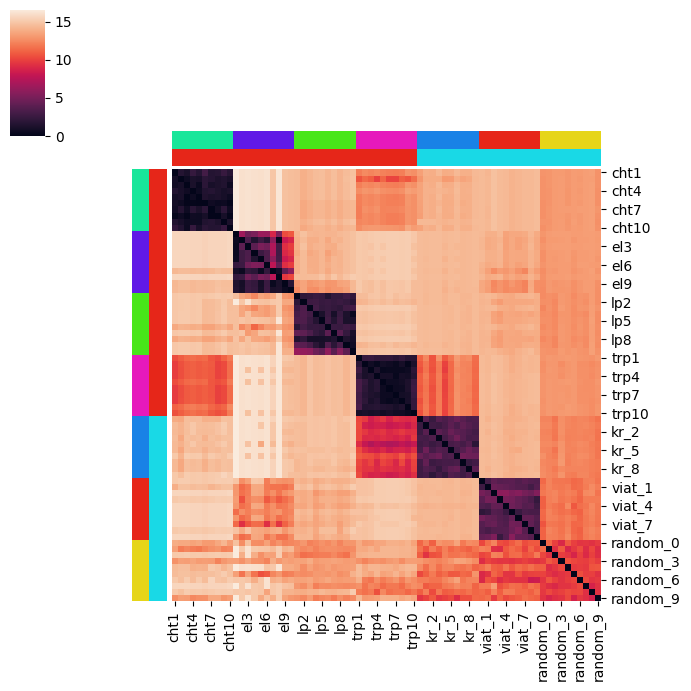

In [18]:
import seaborn as sns

labels1 = design["group"]
lut = dict(zip(set(labels1), sns.hls_palette(len(set(labels1)), l=0.5, s=0.8)))
row_colors1 = design["group"].map(lut)

labels2 = design["synthetic"]
lut = dict(zip(set(labels2), sns.hls_palette(len(set(labels2)), l=0.5, s=0.8)))
row_colors2 = design["synthetic"].map(lut)

comps_df = pd.DataFrame(comparisons_asym)

sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_cluster=False,row_cluster=False
)

In [19]:
wanted_cols = [col for col in merged.columns if (col.startswith("trp") or col.startswith("kr_"))]
kr_trp = merged[wanted_cols]
kr_trp

,trp1,trp2,trp3,trp4,trp5,trp6,trp7,trp8,trp9,trp10,kr_0,kr_1,kr_2,kr_3,kr_4,kr_5,kr_6,kr_7,kr_8,kr_9
Peptide,,,,,,,,,,,,,,,,,,,,
RKTVTAMDVVYALKR,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALKR,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENVIRDAVTYTEHAKRKTVTAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALK,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,7.0,4.0,3.0,2.0,NaN,3.0,3.0,7.0
KVFLENVIRDAVTYTEHAKRKTVTAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGKGLGKGGAKRHRKVLRDNIQGITK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HAKRKTVTAMDVVYALKRQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VTAMDVVYALKRQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


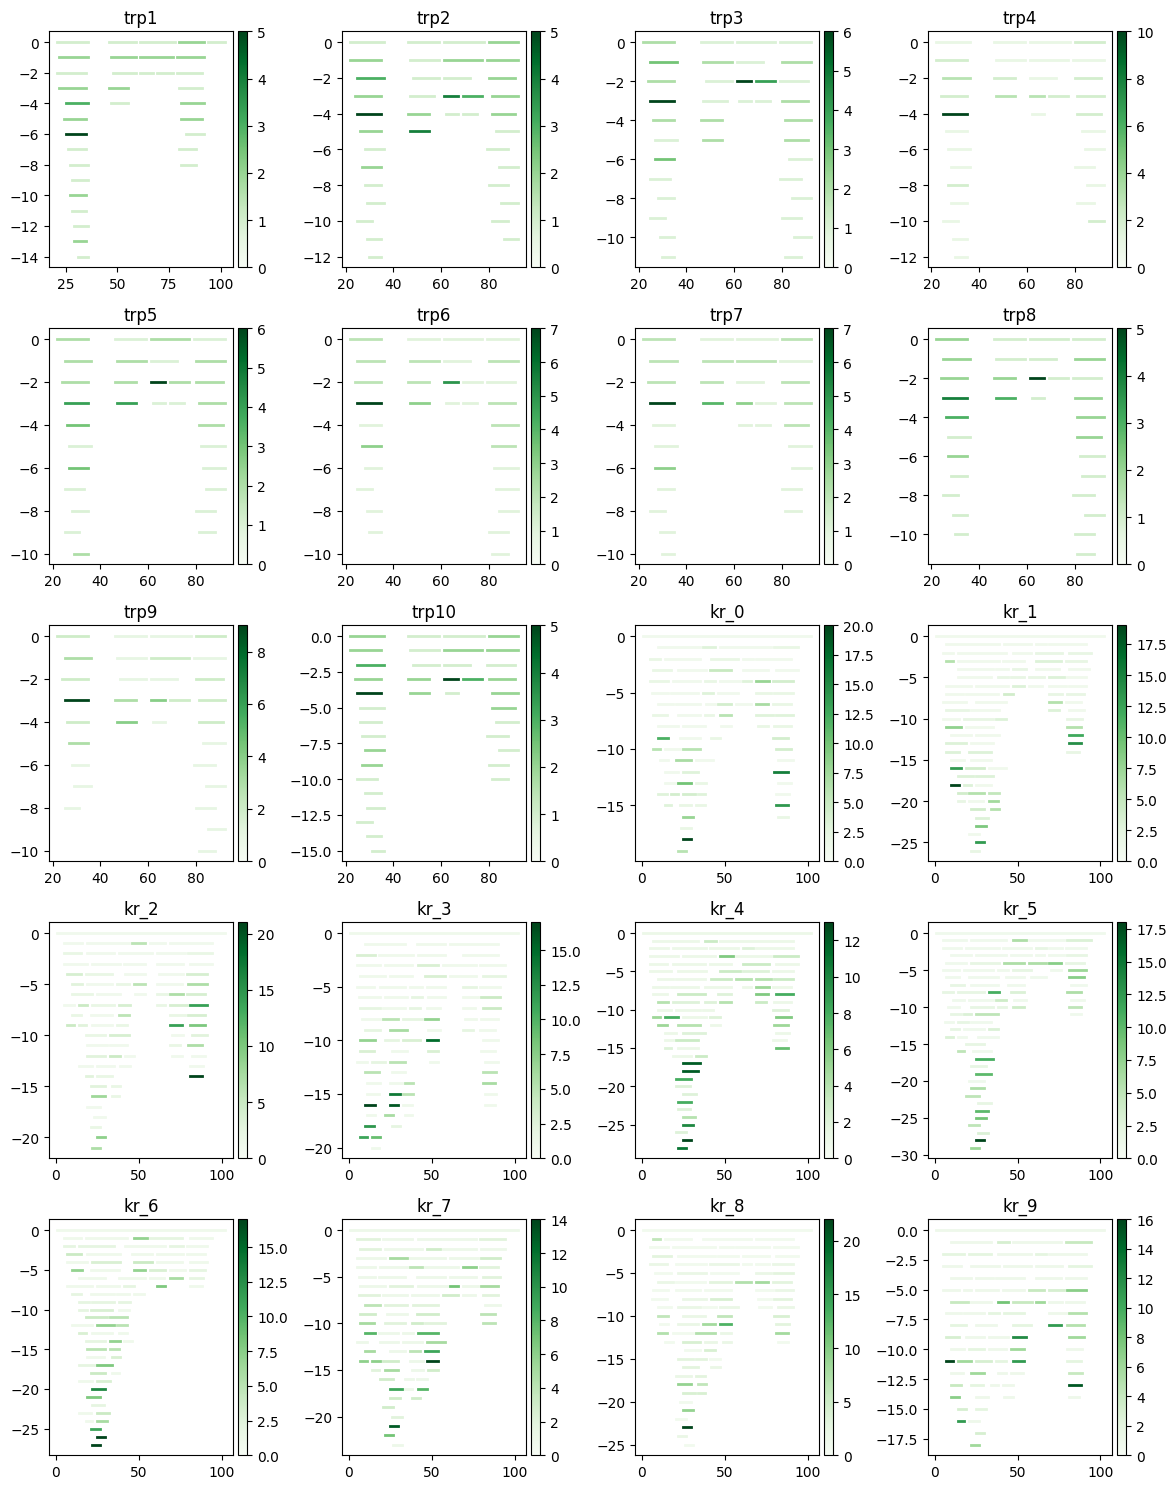

In [20]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(
    5,
    4,
    figsize=(12, 15),
)
samples = kr_trp.columns.tolist()
for col, ax in zip(kr_trp.columns, axs.ravel()):
    d = kr_trp[col]
    i = kr_trp.columns.tolist().index(col)

    ax.set_title(f"{col}")
    d = d.replace(0,np.nan).dropna()

    plot_peptidome(
        protein,
        d,
        ax,
    )
plt.tight_layout()